In [348]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import WMAP5
from MyToolkit import *

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

In [431]:
def find_pi_rp(ra_col, dec_col, red_col, rand_ra_col = None, rand_dec_col = None, rand_red_col = None):
    '''Finds r_p and pi from two catalogs given as three arrays of ra (dec deg), dec (dec deg) and redshift. If only 
    1 catalog is given, finds the pairs between that catalog and itself
    '''
    if((rand_ra_col is None) and (rand_dec_col is None) and (rand_red_col is None)):
        rand_ra_col = ra_col
        rand_dec_col = dec_col
        rand_red_col = red_col

    dist_sq1 = np.square(np.array(Distance(z=red_col)))
    dist_sq2 = np.square(np.array(Distance(z=rand_red_col)))
    v1_sq, v2_sq = np.meshgrid(dist_sq1, dist_sq2)

    ps1_quasars1 = SkyCoord(ra_col*u.deg, dec_col*u.deg, Distance(z=red_col))
    ps1_quasars2 = SkyCoord(rand_ra_col*u.deg, rand_dec_col*u.deg, Distance(z=rand_red_col))
    ps1_quasars1.representation_type = 'cartesian'
    ps1_quasars2.representation_type = 'cartesian'
    
    x1 = np.array(ps1_quasars1.x)
    y1 = np.array(ps1_quasars1.y)
    z1 = np.array(ps1_quasars1.z)
    x2 = np.array(ps1_quasars2.x)
    y2 = np.array(ps1_quasars2.y)
    z2 = np.array(ps1_quasars2.z)    
    x1, x2 = np.meshgrid(x1, x2)
    y1, y2 = np.meshgrid(y1, y2)
    z1, z2 = np.meshgrid(z1, z2)

    v1_v2 = x1*x2 + y1*y2 + z1*z2

    pi_array = np.absolute((v2_sq - v1_sq)/np.sqrt(v1_sq + v2_sq + 2 * v1_v2))
    rp_array = np.sqrt(np.absolute(v1_sq + v2_sq - 2 * v1_v2 - np.square(pi_array)))

    pi_array = pi_array[np.triu_indices(len(pi_array),k = 1)]
    rp_array = rp_array[np.triu_indices(len(rp_array),k = 1)]

    return pi_array, rp_array
    #return v1_sq, v2_sq, v1_v2

def make_rand_cat(num):
    ind = np.where(np.arange(num) > -1)
    rand_ra = np.zeros(num)
    rand_dec = np.zeros(num)
    while True:
        ### using Archimede's theorem
        rand_ra[ind] = np.random.uniform(0, 360, len(ind[0]))
        rand_dec[ind] = np.degrees(np.arcsin(np.random.uniform(-0.5, 1, len(ind[0]))))
        ind = np.where(np.absolute(np.arcsin(np.cos(np.radians(rand_dec)) * np.cos(np.radians(27.4)) * np.cos(np.radians(rand_ra - 192.25)) \
                                            + np.sin(np.radians(rand_dec)) * np.sin(np.radians(27.4)))) < np.radians(20))
        if(len(ind[0]) == 0):
            break

    rand_red = np.random.uniform(5.7, 6.2, num)

    return rand_ra, rand_dec, rand_red

def find_wp_rp_single_bin(ra, dec, red, file_name):
    rand_ra, rand_dec, rand_red = make_rand_cat(len(ra))

    pi_array, rp_array = find_pi_rp(ra, dec, red)
    rand_pi_array, rand_rp_array = find_pi_rp(rand_ra, rand_dec, rand_red)
    cross_pi_array, cross_rp_array = find_pi_rp(ra, dec, red, rand_ra_col=rand_ra,\
                                                rand_dec_col=rand_dec, rand_red_col=rand_red)

    rp_bins = np.float_power(10, np.arange(34) * 0.15)
    rp_mid = (rp_bins[:-1] + rp_bins[1:])/2

    rp_hist = (plt.hist(rp_array, rp_bins)[0]).astype(int)
    rand_rp_hist = (plt.hist(rand_rp_array, rp_bins)[0]).astype(int)
    cross_rp_hist = (plt.hist(cross_rp_array, rp_bins)[0]).astype(int)
    plt.close()

    unfin_pos = np.where(rp_hist * rand_rp_hist * cross_rp_hist == 0)

    with np.errstate(divide='ignore', invalid='ignore'):
        xi_rp = (rp_hist - 2 * cross_rp_hist + rand_rp_hist)/rand_rp_hist
    xi_rp[unfin_pos] = 0

    file = open(file_name + ".txt", 'w')
    file.write('   rp_mid       DD      RR      DR      xi_rp \n')
    for i in range(len(rp_mid)):
        file.write(f'{rp_mid[i]:9.3f}   {rp_hist[i]:5d}    {rand_rp_hist[i]:5d}   {cross_rp_hist[i]:5d}   {xi_rp[i]:8.5f}\n')

    #xi_rp = np.abs(xi_rp)
    #(rp_hist + rand_rp_hist - 2 * cross_rp_hist)/rand_rp_hist
    plt.plot(rp_mid, xi_rp, '*-')
    plt.ylabel(r'$w_p(r_p)$')
    plt.xlabel(r'$r_p (Mpc)$')
    plt.axhline(0, ls = '--', lw = 0.5, c = 'black')

In [350]:
schind_23_file_name = DP2_DIRECTORY + "Data/apjaca7cat7_ascii.txt"
schind_23_data = open(schind_23_file_name, 'r')
ra_col_schind_23 = []
dec_col_schind_23 = []
red_col_schind_23 = []

skip_rows = 6
for line in schind_23_data:
    if (skip_rows > 0):
        skip_rows -= 1
        continue
    split_line = line.split()
    quasar_name = split_line[0] 
    red_col_schind_23.append(float(split_line[2]))
    ra_col_schind_23.append(float(quasar_name[4:13]))
    dec_col_schind_23.append(float(quasar_name[13:21]))
    
ra_col_schind_23 = np.array(ra_col_schind_23)
dec_col_schind_23 = np.array(dec_col_schind_23)
red_col_schind_23 = np.array(red_col_schind_23)
    

### Final function to find the $w_p(r_p)$ by only binning quasars on $r_p$. 
`find_wp_rp_single_bin(ra_column, dec_column, redshift_column, file_name_to_write_wp)`

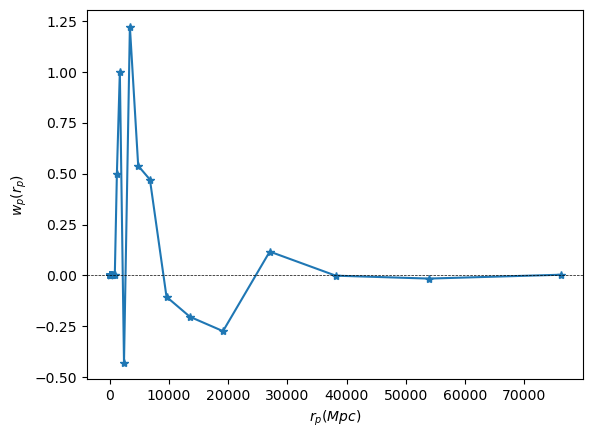

In [432]:
find_wp_rp_single_bin(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, "projected_corr_table_real_signal")

### $\pi$ vs $r_p$ for the real quasar sample

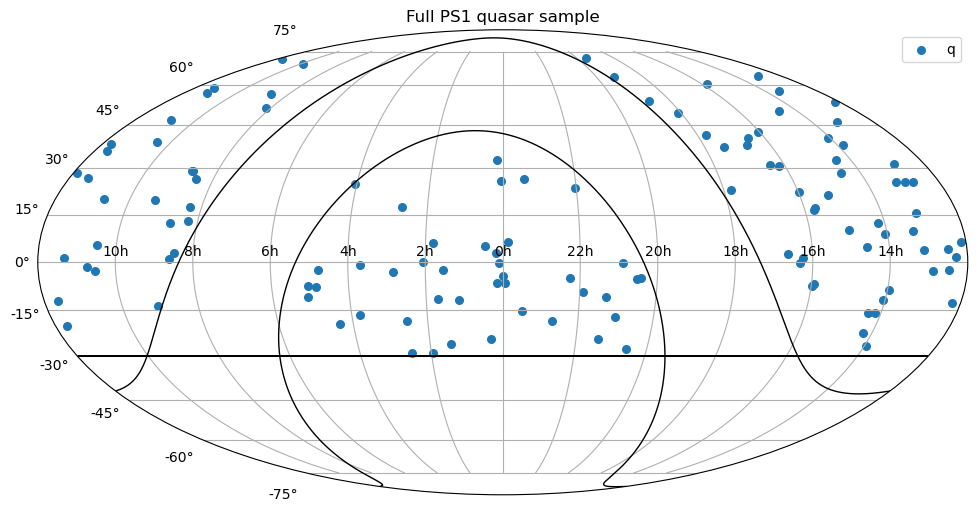

In [429]:
plot_sky_map_ps1(ra_col_schind_23, dec_col_schind_23,labels = 'quasars', title="Full PS1 quasar sample")

Text(0, 0.5, '$r_p$')

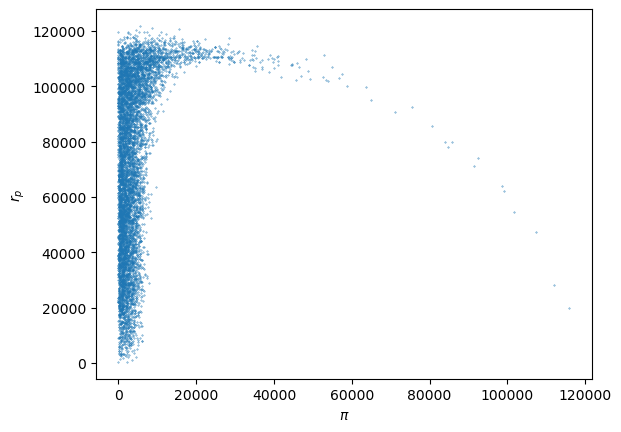

In [351]:
pi_array, rp_array = find_pi_rp(ra_col_schind_23, dec_col_schind_23, red_col_schind_23)

plt.scatter(pi_array, rp_array, s = 0.1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")

### Now we try to make a random catalog

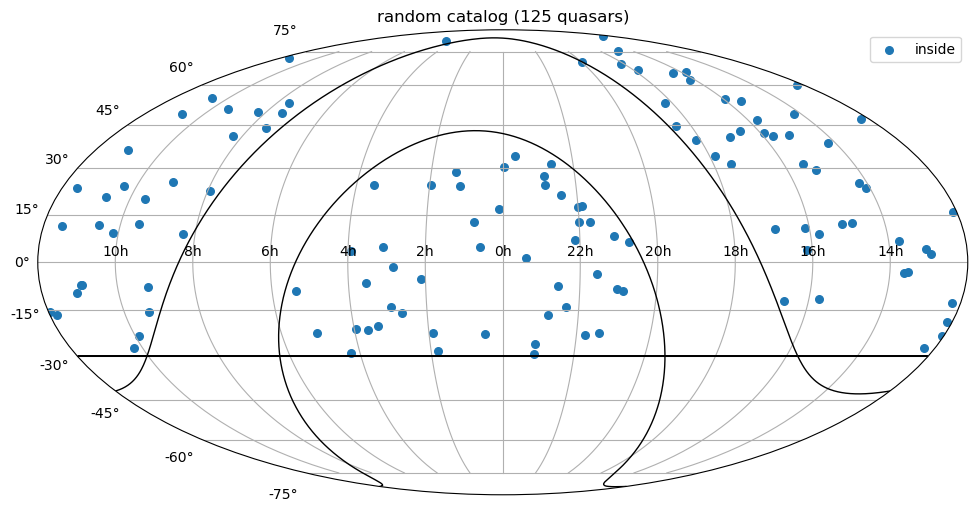

In [433]:
rand_ra, rand_dec, rand_red = make_rand_cat(len(ra_col_schind_23))

# rand_mask = np.zeros_like(rand_ra, dtype='int')
# rand_mask[ind] = 1
# rand_mask = np.insert(rand_mask, 0 , 2)
plot_sky_map_ps1(rand_ra, rand_dec, labels=['inside', 'outside'], title = "random catalog (125 quasars)")

Text(0, 0.5, '$r_p$')

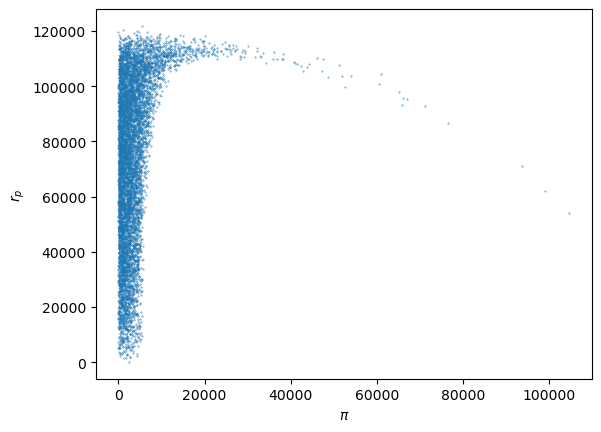

In [353]:
rand_pi_array, rand_rp_array = find_pi_rp(rand_ra, rand_dec, rand_red)

plt.scatter(rand_pi_array, rand_rp_array, s = 0.1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")

### We will find the cross catalogue $r_p$ and $\pi$

Text(0, 0.5, '$r_p$')

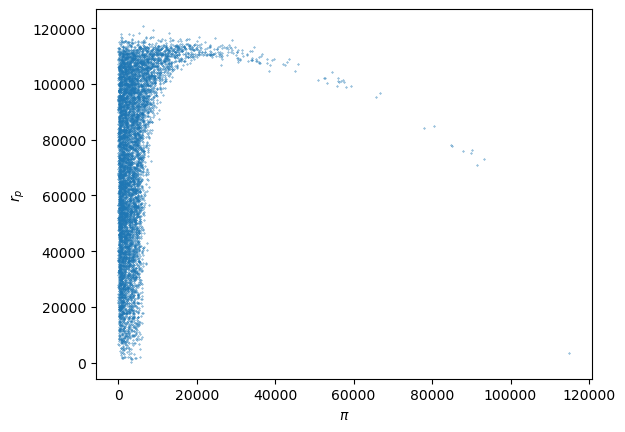

In [354]:
cross_pi_array, cross_rp_array = find_pi_rp(ra_col_schind_23, dec_col_schind_23, red_col_schind_23,\
                                             rand_ra_col = rand_ra, rand_dec_col = rand_dec, rand_red_col = rand_red)

plt.scatter(cross_pi_array, cross_rp_array, s = 0.1)
#plt.xlim(0, 10000)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")


### Here we try to implement the landy szalay estimator using the $r_p$ and $\pi$

#### $w_p$ calculated from considering the pairs only in $r_p$ bin

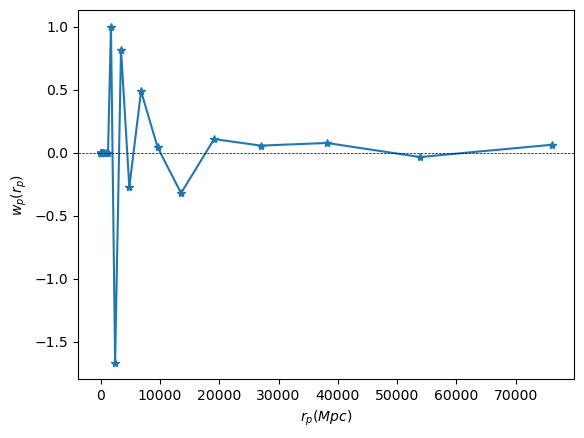

In [480]:
find_wp_rp_single_bin(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, "projected_corr_table_real_signal")

#### $w_p$ of a random distribution calculated from considering the pairs only in $r_p$ bin.

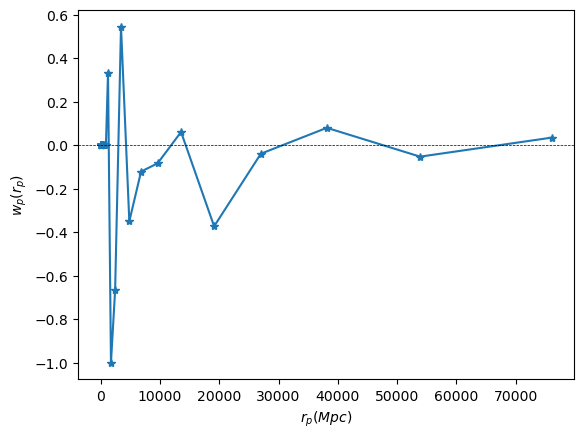

In [473]:
rand_ra2, rand_dec2, rand_red2 = make_rand_cat(125)
find_wp_rp_single_bin(rand_ra2, rand_dec2, rand_red2, "projected_corr_table_rand_signal")

#### $w_p$ of a random distribution of large size

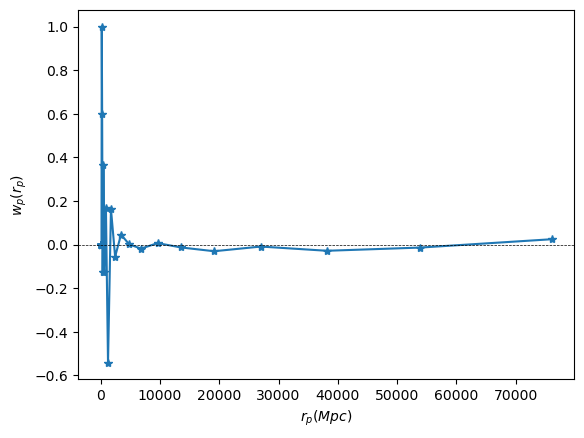

In [505]:
rand_ra2, rand_dec2, rand_red2 = make_rand_cat(1000)
find_wp_rp_single_bin(rand_ra2, rand_dec2, rand_red2, "projected_corr_table_rand_signal")

#### $\xi(r_p, \pi)$ calculated from $r_p$ and $\pi$ bins

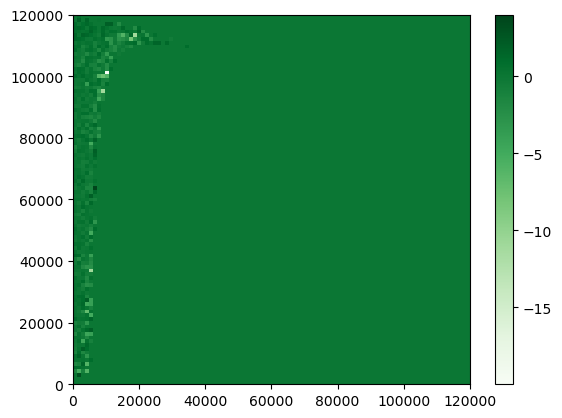

In [357]:
### making the bins of r_p and pi
Max_dist = 2 * Distance(z=6.2).value

pi_bins = np.linspace(0, 120000, 100)
#rp_bins = np.float_power(10, np.arange(34) * 0.15)
rp_bins = np.linspace(0, 120000, 100)

### counting the number of pairs in each bin
pi_rp_hist = plt.hist2d(pi_array, rp_array, [pi_bins, rp_bins])[0];
rand_pi_rp_hist = plt.hist2d(rand_pi_array, rand_rp_array, [pi_bins, rp_bins])[0];
cross_pi_rp_hist = plt.hist2d(cross_pi_array, cross_rp_array, [pi_bins, rp_bins])[0];
#plt.close()

### Normalising the number of pairs in each bin
### by deviding by the total number of pairs
pi_rp_hist = pi_rp_hist/np.sum(pi_rp_hist)
rand_pi_rp_hist = rand_pi_rp_hist/np.sum(rand_pi_rp_hist)
cross_pi_rp_hist = cross_pi_rp_hist/np.sum(cross_pi_rp_hist)

fin_pos = np.nonzero(pi_rp_hist * rand_pi_rp_hist * cross_pi_rp_hist)
unfin_pos = np.where((pi_rp_hist * rand_pi_rp_hist * cross_pi_rp_hist) == 0)

with np.errstate(divide='ignore', invalid='ignore'):
    xi_pi_rp = (pi_rp_hist + rand_pi_rp_hist - 2 * cross_pi_rp_hist)/rand_pi_rp_hist
xi_pi_rp[unfin_pos] = 0
xi_pi_rp

mesh_rp_bins, mesh_pi_bins = np.meshgrid(pi_bins, rp_bins)

c = plt.pcolormesh(mesh_pi_bins, mesh_rp_bins, xi_pi_rp, cmap = 'Greens')
plt.colorbar(c)

### Here we are demonstrating that the shape of $r_p$ vs $\pi$ graph is correct, by choosing a random distribution of objects in a 2d ring and calculating their $r_p$ and $\pi$.

In [358]:
def pi_fun(r1, r2, theta1, theta2):
    num = r2**2 - r1**2
    dinom = np.sqrt(r1**2 + r2**2 + 2 * r1 * r2 * np.cos(theta1 - theta2))
    return num/dinom

def rp_fun(r1, r2, theta1, theta2):
    num = r1**2 * r2**2 * (np.sin(theta1 - theta2))**2
    dinom = r1**2 + r2**2 + 2 * r1 * r2 * np.cos(theta1 - theta2)
    return 2 * np.sqrt(num/dinom)

In [359]:
r1 = 10000 + 10 * np.random.rand(1000)
r2, r1 = np.meshgrid(r1, r1)
theta1 = 2*np.pi * np.random.rand(1000)
theta2, theta1 = np.meshgrid(theta1, theta1)

v_pi_fun = np.vectorize(pi_fun)
v_rp_fun = np.vectorize(rp_fun)

pi_plot_array = np.absolute(pi_fun(r1, r2, theta1, theta2))
rp_plot_array = rp_fun(r1, r2, theta1, theta2)

pi_plot_array = pi_plot_array[np.triu_indices(len(pi_plot_array),k = 1)]
rp_plot_array = rp_plot_array[np.triu_indices(len(rp_plot_array),k = 1)]

Text(0, 0.5, '$r_p$')

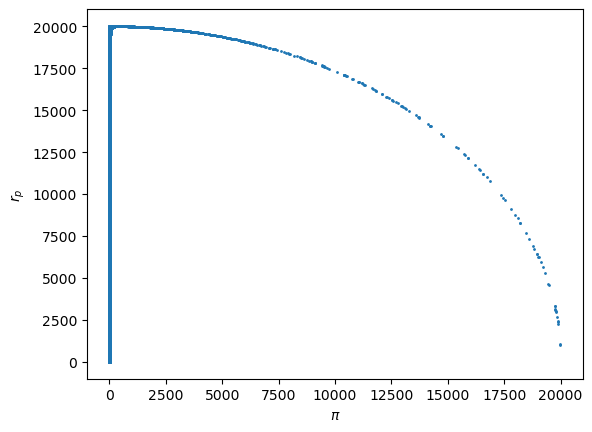

In [360]:
plt.scatter(pi_plot_array, rp_plot_array, s = 1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")